<h1 style="text-align:center; font-size:40px;">Machine Learning Project by:<br> Solomon Sugamo and Bona Geleta</h1>

<br>

# Machine Learning Project 
## Data used: Cybersecurity Data

In [164]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Load the dataset and display basic information

In [167]:
# Load the dataset
data = pd.read_csv('cybersecurity_large_synthesized_data.csv')

In [169]:
# Display basic information about the dataset
print("Initial Data Overview:")
print(f"Shape of the dataset: {data.shape}")
print("")
print("")
print("Columns:", data.columns.tolist())
print("")
print("")
print("sample data colums with values") 
print(data.head())
print("")
print("")
print("\nData Types:")
print(data.dtypes)

Initial Data Overview:
Shape of the dataset: (100000, 15)


Columns: ['attack_type', 'target_system', 'outcome', 'timestamp', 'attacker_ip', 'target_ip', 'data_compromised_GB', 'attack_duration_min', 'security_tools_used', 'user_role', 'location', 'attack_severity', 'industry', 'response_time_min', 'mitigation_method']


sample data colums with values
        attack_type  target_system  outcome                   timestamp  \
0          Phishing  Cloud Service  Failure  2024-04-03 11:13:15.083419   
1              DDoS   Email Server  Success  2024-02-03 20:51:56.083463   
2  Zero-Day Exploit  Cloud Service  Success  2024-07-19 18:40:05.083472   
3     SQL Injection   Email Server  Failure  2023-12-08 00:54:17.083478   
4  Zero-Day Exploit     IoT Device  Failure  2024-07-23 05:38:20.083483   

       attacker_ip        target_ip  data_compromised_GB  attack_duration_min  \
0      21.166.79.4      23.20.50.78                15.31                  300   
1  187.180.150.169    34.160.58.2

In [171]:
print("\nMissing Values Per Column:")
print(data.isnull().sum())


Missing Values Per Column:
attack_type            0
target_system          0
outcome                0
timestamp              0
attacker_ip            0
target_ip              0
data_compromised_GB    0
attack_duration_min    0
security_tools_used    0
user_role              0
location               0
attack_severity        0
industry               0
response_time_min      0
mitigation_method      0
dtype: int64


### No missing value shown from the original data. So there is no need to handle missing values

<br>

In [175]:
# Check for Duplicates
duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


### No duplicate value shown from the original data. So there is no need to handle duplicates

<br>

## Checking Outliers for numeric columns

In [180]:
# Identify numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Initial Outlier Detection
print("Initial Outlier Detection:")
outliers_count_initial = {}
outliers_initial = {}

for col in numerical_cols:
    # Calculate Q1, Q3, and IQR
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    outliers_count_initial[col] = len(outliers)
    outliers_initial[col] = outliers  # Store outliers for examination

# Display initial outlier counts per column
print("Number of initial outliers per column:")
for col, count in outliers_count_initial.items():
    print(f"{col}: {count} outliers")

Initial Outlier Detection:
Number of initial outliers per column:
data_compromised_GB: 0 outliers
attack_duration_min: 0 outliers
attack_severity: 0 outliers
response_time_min: 0 outliers


### The output shows 0 outliers for all numeric columns, there is no need to handle outliers.

<br>

### Feature Engineering for timestamp

#### Extract useful time-based features (e.g., year, month, day_of_week, hour)

In [186]:
# Check the unique years in the 'timestamp' column
data['timestamp'] = pd.to_datetime(data['timestamp'])  # Ensure 'timestamp' is in datetime format
unique_years = data['timestamp'].dt.year.unique()
print("Unique years in data:", unique_years)

Unique years in data: [2024 2023]


Feature Extraction from timestamp

In [189]:
# Ensure 'timestamp' is in datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Extract year, month, day of the week, and hour
data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['hour'] = data['timestamp'].dt.hour

In [191]:
# Preview to verify extracted features alongside the original timestamp
print(data[['timestamp', 'year', 'month', 'day_of_week', 'hour']].head(10))

                   timestamp  year  month  day_of_week  hour
0 2024-04-03 11:13:15.083419  2024      4            2    11
1 2024-02-03 20:51:56.083463  2024      2            5    20
2 2024-07-19 18:40:05.083472  2024      7            4    18
3 2023-12-08 00:54:17.083478  2023     12            4     0
4 2024-07-23 05:38:20.083483  2024      7            1     5
5 2024-08-19 19:15:30.083491  2024      8            0    19
6 2024-05-09 18:29:57.083499  2024      5            3    18
7 2024-08-12 17:02:28.083508  2024      8            0    17
8 2024-09-01 10:41:31.083515  2024      9            6    10
9 2024-05-08 06:10:28.083521  2024      5            2     6


In [193]:
# Drop the 'timestamp' column since features have been successfully extracted
data.drop(columns=['timestamp'], inplace=True)

.

### Feature engeenering attacker_ip and target_ip

#### Determine whether the IP addresses in attacker_ip and target_ip are private (internal) or public (globally routable).

Reminder: Ranges for IPv4 private IP addresses:    
Class A: 10.0.0.0 to 10.255.255.255        
Class B: 172.16.0.0 to 172.31.255.255        
Class C: 192.168.0.0 to 192.168.255.255

In [199]:
import ipaddress

# check if an IP address is private
def is_private_ip(ip):
    try:
        return ipaddress.ip_address(ip).is_private
    except ValueError:
        # Return None if the IP is invalid (handle any malformed IP addresses)
        return None

# Apply the function to attacker_ip and target_ip columns
data['attacker_is_private'] = data['attacker_ip'].apply(is_private_ip)
data['target_is_private'] = data['target_ip'].apply(is_private_ip)

# Check the results
print("Private IP count in 'attacker_ip':", data['attacker_is_private'].sum())
print("Private IP count in 'target_ip':", data['target_is_private'].sum())

Private IP count in 'attacker_ip': 7045
Private IP count in 'target_ip': 7186


<br>

In [202]:
# I want to Keep attacker_ip, target_ip, of private/public classification
# So I drop 'attacker_ip' and 'target_ip' columns b/c it is transformed to private/public

data.drop(columns=['attacker_ip', 'target_ip'], inplace=True)

<br>

### Visualizing the data

We used random sampling to make respresentative data and to minimize data load

We also Log transform numerical columns with large ranges for better visualization

In [209]:
# Count unique values in categorical columns
print("\nUnique Value Counts for Categorical Columns:")
for col in data.select_dtypes(include='object').columns:
    print(f"{col}: {data[col].nunique()} unique values")


Unique Value Counts for Categorical Columns:
attack_type: 8 unique values
target_system: 8 unique values
outcome: 2 unique values
security_tools_used: 8 unique values
user_role: 4 unique values
location: 10 unique values
industry: 8 unique values
mitigation_method: 5 unique values


<br>

In [212]:
print("Data types:", data.dtypes)
print("")
print("Sample cleaned data:")
print(data.head())

Data types: attack_type             object
target_system           object
outcome                 object
data_compromised_GB    float64
attack_duration_min      int64
security_tools_used     object
user_role               object
location                object
attack_severity          int64
industry                object
response_time_min        int64
mitigation_method       object
year                     int32
month                    int32
day_of_week              int32
hour                     int32
attacker_is_private       bool
target_is_private         bool
dtype: object

Sample cleaned data:
        attack_type  target_system  outcome  data_compromised_GB  \
0          Phishing  Cloud Service  Failure                15.31   
1              DDoS   Email Server  Success                65.05   
2  Zero-Day Exploit  Cloud Service  Success                48.99   
3     SQL Injection   Email Server  Failure                16.29   
4  Zero-Day Exploit     IoT Device  Failure           

<br>

#### sampling data for visualization

In [216]:
# Sample the data for visualization (e.g., 10,000 rows)

sample_data = data.sample(n=10000, random_state=42)  

### Log transform is used to reduce skewness and normalize the distribution

In [219]:
# Log transform numerical columns with large ranges
# the purpose is to reduce skewness and handle outliers
sample_data['log_data_compromised_GB'] = np.log1p(sample_data['data_compromised_GB'])
sample_data['log_attack_duration_min'] = np.log1p(sample_data['attack_duration_min'])
sample_data['log_response_time_min'] = np.log1p(sample_data['response_time_min'])

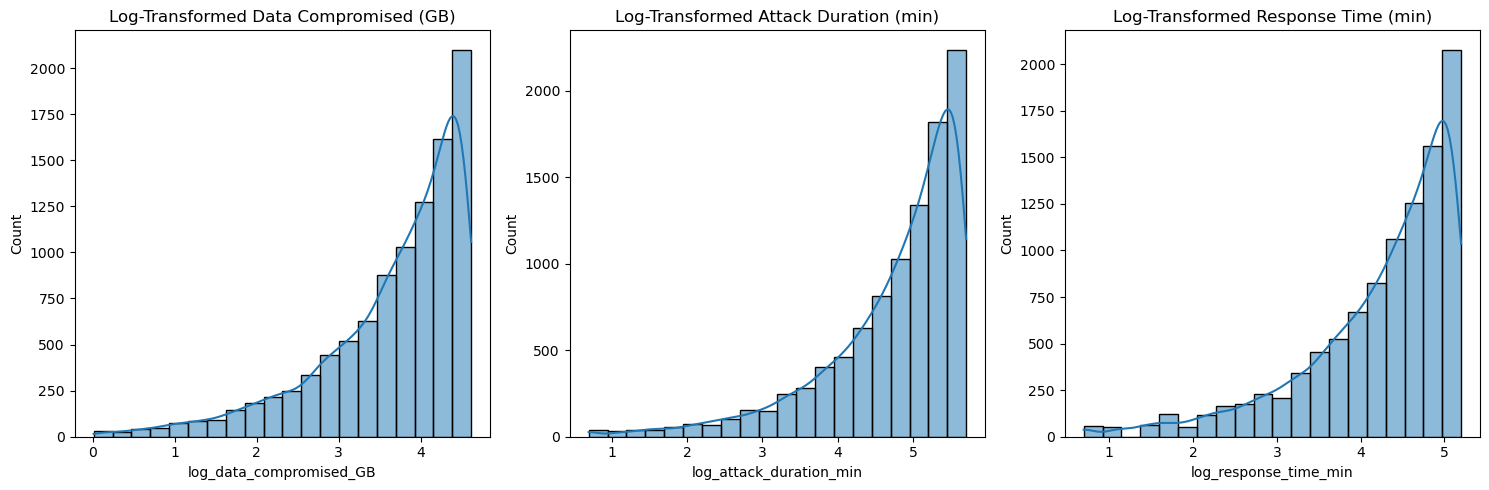

In [221]:
# Visualize log-transformed numerical columns
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(sample_data['log_data_compromised_GB'], bins=20, kde=True)
plt.title('Log-Transformed Data Compromised (GB)')
plt.subplot(1, 3, 2)
sns.histplot(sample_data['log_attack_duration_min'], bins=20, kde=True)
plt.title('Log-Transformed Attack Duration (min)')
plt.subplot(1, 3, 3)
sns.histplot(sample_data['log_response_time_min'], bins=20, kde=True)
plt.title('Log-Transformed Response Time (min)')
plt.tight_layout()
plt.show()


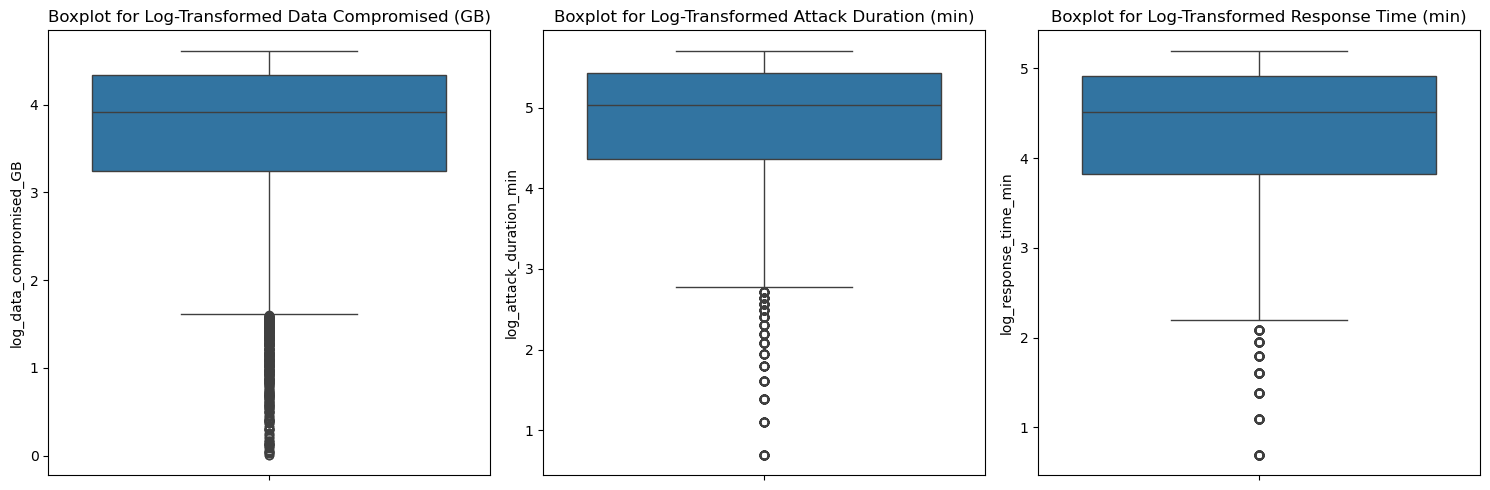

In [224]:
# Additional box plots for log-transformed numerical columns
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(y=sample_data['log_data_compromised_GB'])
plt.title('Boxplot for Log-Transformed Data Compromised (GB)')
plt.subplot(1, 3, 2)
sns.boxplot(y=sample_data['log_attack_duration_min'])
plt.title('Boxplot for Log-Transformed Attack Duration (min)')
plt.subplot(1, 3, 3)
sns.boxplot(y=sample_data['log_response_time_min'])
plt.title('Boxplot for Log-Transformed Response Time (min)')
plt.tight_layout()
plt.show()

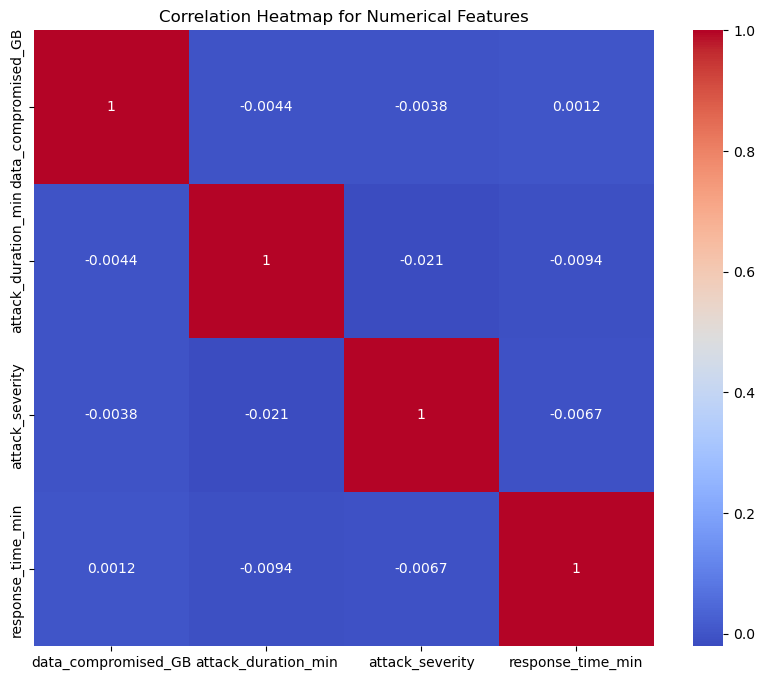

In [226]:
# Correlation heatmap for numerical columns
numerical_cols = ['data_compromised_GB', 'attack_duration_min', 'attack_severity', 'response_time_min']
plt.figure(figsize=(10, 8))
sns.heatmap(sample_data[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap for Numerical Features")
plt.show()

<br>

 ## Encoding

### Label Encoding for Binary Categorical Columns

In [231]:
from sklearn.preprocessing import LabelEncoder

# Label Encode binary categorical columns
# b/c it is space-efficient and keeps the feature count low but One-hot encoding would create two separate columns
binary_columns = ['outcome', 'attacker_is_private', 'target_is_private']

label_encoder = LabelEncoder()
for col in binary_columns:
    data[col] = label_encoder.fit_transform(data[col])

### One-Hot Encode nominal categorical columns

In [234]:
# One-Hot Encode nominal categorical columns
nominal_columns = [
    'attack_type', 'target_system', 'security_tools_used', 
    'user_role', 'location', 'industry', 'mitigation_method'
]

data = pd.get_dummies(data, columns=nominal_columns, drop_first=True)

<br>

## Display the data

In [238]:
# Display the dataset after encoding
print("Data after encoding categorical features:")
print(data.head())

Data after encoding categorical features:
   outcome  data_compromised_GB  attack_duration_min  attack_severity  \
0        0                15.31                  300                2   
1        1                65.05                  242               10   
2        1                48.99                  120                7   
3        0                16.29                  286                3   
4        0                87.66                    4                6   

   response_time_min  year  month  day_of_week  hour  attacker_is_private  \
0                164  2024      4            2    11                    0   
1                 64  2024      2            5    20                    0   
2                 87  2024      7            4    18                    0   
3                 23  2023     12            4     0                    0   
4                129  2024      7            1     5                    0   

   ...  industry_Finance  industry_Government  industry_

<br>

## Scaling Numerical Columns

In [243]:
from sklearn.preprocessing import StandardScaler

# It changes the scale but keeps the original distribution shape
# List of numerical columns to scale
numerical_columns = [
    'data_compromised_GB', 'attack_duration_min', 'attack_severity', 
    'response_time_min', 'year', 'month', 'day_of_week', 'hour'
]

# Initialize the scaler
scaler = StandardScaler()

# Apply Standard Scaling
# each column will have a mean of approximately 0 and a standard deviation of approximately 1
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Display a sample of the scaled data
print("Data after scaling numerical features:")
print(data[numerical_columns].head())

Data after scaling numerical features:
   data_compromised_GB  attack_duration_min  attack_severity  \
0            -1.205448             1.717105        -1.219286   
1             0.519862             1.048385         1.568458   
2            -0.037204            -0.358233         0.523054   
3            -1.171455             1.555690        -0.870818   
4             1.304125            -1.695674         0.174586   

   response_time_min      year     month  day_of_week      hour  
0           1.416923  0.685679 -0.726612    -0.499182 -0.070778  
1          -0.509669  0.685679 -1.306297     1.005420  1.233251  
2          -0.066553  0.685679  0.142916     0.503886  0.943467  
3          -1.299572 -1.458408  1.592128     0.503886 -1.664592  
4           0.742616  0.685679  0.142916    -1.000716 -0.940131  


<br>

<br>

#### Define the scaled numerical columns

In [248]:
# Scale only the numerical columns
scaler = StandardScaler()
data_scaled_numerical = scaler.fit_transform(data[numerical_columns])

<br>

#### Combining scaled numerical data with categorical/binary data

In [252]:
# Reassemble the dataset by combining scaled numerical data with categorical/binary data
data_for_pca = pd.concat([
    pd.DataFrame(data_scaled_numerical, columns=numerical_columns),
    data.drop(columns=numerical_columns).reset_index(drop=True)  # Retain other features as they are
], axis=1)


#### PCA for clustering

In [265]:
from sklearn.decomposition import PCA

In [267]:
# Apply PCA
pca = PCA(n_components=2)  # I make it 2 to visualize high-dimensional data in a 2D plot, but it might sustain information loss
data_pca = pca.fit_transform(data_for_pca)


In [269]:
# Sample the PCA-transformed data for clustering
sampling_fraction = 0.1  # only 10% of the PCA-transformed data is used for clustering
data_sampled_for_clustering = pd.DataFrame(data_pca, columns=['PC1', 'PC2']).sample(frac=sampling_fraction, random_state=42)


In [271]:
# Apply clustering algorithms on sampled PCA-transformed data
results = {}
algorithms = {
    'KMeans': KMeans(n_clusters=3, random_state=42),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=3),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
}

for name, model in algorithms.items():
    labels = model.fit_predict(data_sampled_for_clustering)
    if len(set(labels)) > 1:  # Ensure more than one cluster is found
        silhouette_avg = silhouette_score(data_sampled_for_clustering, labels)
        davies_bouldin = davies_bouldin_score(data_sampled_for_clustering, labels)
        results[name] = {
            'Silhouette Score': silhouette_avg,
            'Davies-Bouldin Index': davies_bouldin,
            'Labels': labels
        }
        print(f"{name}:")
        print(f"Silhouette Score: {silhouette_avg}")
        print(f"Davies-Bouldin Index: {davies_bouldin}")
        print("=" * 40)
    else:
        print(f"{name} found only one cluster; skipping metrics.")

KMeans:
Silhouette Score: 0.4768154297117614
Davies-Bouldin Index: 0.7532755308547595
AgglomerativeClustering:
Silhouette Score: 0.44420428550852487
Davies-Bouldin Index: 0.7667112146803176
DBSCAN:
Silhouette Score: 0.5362467542263261
Davies-Bouldin Index: 0.541718574723106


##### - Silhouette Score ranges from -1 to 1. 1 for Perfect clustering and -1 for poor clustering     
##### - Davies-Bouldin Index Higher Values for Worse clustering and 0 for Perfect clustering

#### DBSCAN has the best performance from the list with Silhouette Score of 0.5362 and Davies-Bouldin Index of 0.5417.   
#### However, the value is still very low

<br>

#### Plot the clustering for visualization

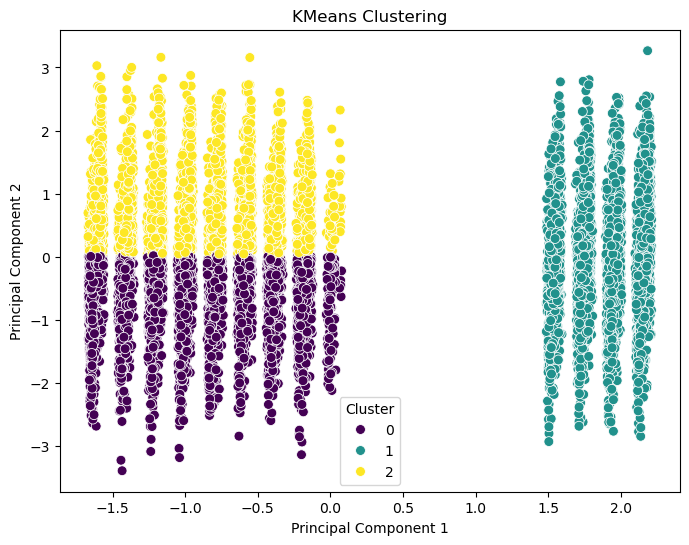

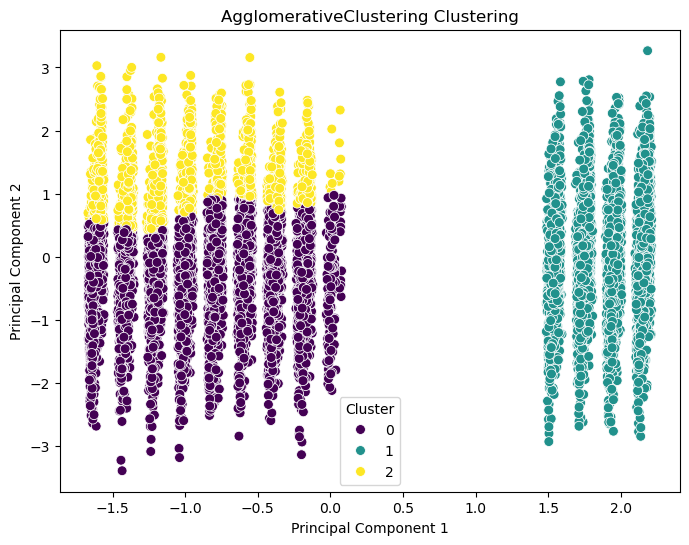

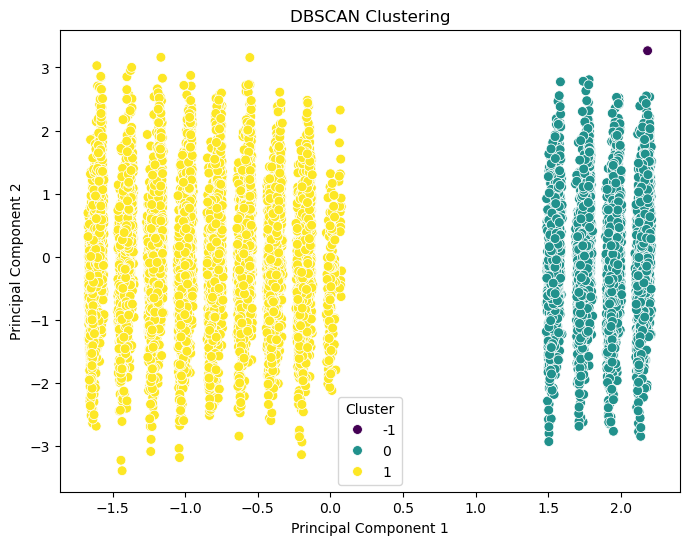

In [277]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to plot clustering results
def plot_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels, palette='viridis', s=50, marker="o")
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster")
    plt.show()

# Plot each clustering result with appropriate titles
for name, result in results.items():
    plot_clusters(data_sampled_for_clustering.values, result['Labels'], f"{name} Clustering")


<br>

## Classification

### see the basic information about the data again

In [282]:
# Display basic information about the dataset
print("Basic Information about the Dataset:")
print(data.info())  # Provides column names, data types, and non-null counts


Basic Information about the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 55 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   outcome                                 100000 non-null  int32  
 1   data_compromised_GB                     100000 non-null  float64
 2   attack_duration_min                     100000 non-null  float64
 3   attack_severity                         100000 non-null  float64
 4   response_time_min                       100000 non-null  float64
 5   year                                    100000 non-null  float64
 6   month                                   100000 non-null  float64
 7   day_of_week                             100000 non-null  float64
 8   hour                                    100000 non-null  float64
 9   attacker_is_private                     100000 non-null  int64  
 10  target_i

In [284]:
# Check for any missing values
print("\nMissing Values Per Column:")
print(data.isnull().sum())


Missing Values Per Column:
outcome                                   0
data_compromised_GB                       0
attack_duration_min                       0
attack_severity                           0
response_time_min                         0
year                                      0
month                                     0
day_of_week                               0
hour                                      0
attacker_is_private                       0
target_is_private                         0
attack_type_Cross-Site Scripting          0
attack_type_DDoS                          0
attack_type_Malware                       0
attack_type_Phishing                      0
attack_type_Ransomware                    0
attack_type_SQL Injection                 0
attack_type_Zero-Day Exploit              0
target_system_Cloud Service               0
target_system_Database                    0
target_system_Email Server                0
target_system_IoT Device                  0
targ

In [286]:
# Display basic statistics for numerical columns
print("\nSummary Statistics for Numerical Columns:")
print(data.describe())  # Shows count, mean, std, min, max, and quartiles for numerical features


Summary Statistics for Numerical Columns:
             outcome  data_compromised_GB  attack_duration_min  \
count  100000.000000         1.000000e+05         1.000000e+05   
mean        0.500300         5.286438e-17        -1.146816e-16   
std         0.500002         1.000005e+00         1.000005e+00   
min         0.000000        -1.736499e+00        -1.730263e+00   
25%         0.000000        -8.634381e-01        -8.655382e-01   
50%         1.000000        -8.968556e-05        -8.138785e-04   
75%         1.000000         8.639525e-01         8.639104e-01   
max         1.000000         1.732157e+00         1.717105e+00   

       attack_severity  response_time_min          year         month  \
count     1.000000e+05       1.000000e+05  1.000000e+05  1.000000e+05   
mean     -4.263256e-19       1.129763e-16 -2.883480e-14 -4.796163e-18   
std       1.000005e+00       1.000005e+00  1.000005e+00  1.000005e+00   
min      -1.567754e+00      -1.723423e+00 -1.458408e+00 -1.596139e+00 

In [288]:
# Step 4: Display unique values for categorical columns to understand feature levels
categorical_cols = data.select_dtypes(include=['object', 'bool']).columns
print("\nUnique Values in Categorical Columns:")
for col in categorical_cols:
    print(f"{col}: {data[col].unique()}")


Unique Values in Categorical Columns:
attack_type_Cross-Site Scripting: [False  True]
attack_type_DDoS: [False  True]
attack_type_Malware: [False  True]
attack_type_Phishing: [ True False]
attack_type_Ransomware: [False  True]
attack_type_SQL Injection: [False  True]
attack_type_Zero-Day Exploit: [False  True]
target_system_Cloud Service: [ True False]
target_system_Database: [False  True]
target_system_Email Server: [False  True]
target_system_IoT Device: [False  True]
target_system_Network Switch: [False  True]
target_system_User Account: [False  True]
target_system_Web Server: [False  True]
security_tools_used_Endpoint Detection: [False  True]
security_tools_used_Firewall: [ True False]
security_tools_used_IDS: [False  True]
security_tools_used_MFA: [False  True]
security_tools_used_SIEM: [False  True]
security_tools_used_VPN: [False  True]
security_tools_used_WAF: [False  True]
user_role_Contractor: [False  True]
user_role_Employee: [ True False]
user_role_External User: [False  T

<br>

#### Defining target and features

In [292]:
# Step 1: Define target and features before PCA
target = 'outcome'  
features_to_drop = ['timestamp', 'attacker_is_private', 'target_is_private']  # I considered unnecessary for classification
features = data.drop(columns=[target] + features_to_drop, errors='ignore').columns

X = data[features]  # Feature set without the target and unnecessary columns
y = data[target]  # Target variable

In [294]:
# Scale Numerical Features

from sklearn.preprocessing import StandardScaler
numerical_columns = [
    'data_compromised_GB', 'attack_duration_min', 'attack_severity', 
    'response_time_min', 'year', 'month', 'day_of_week', 'hour'
]

scaler = StandardScaler()
X_scaled_numerical = scaler.fit_transform(X[numerical_columns])

# Combine scaled numerical features with categorical/binary features
X_for_pca = pd.concat([
    pd.DataFrame(X_scaled_numerical, columns=numerical_columns),
    X.drop(columns=numerical_columns).reset_index(drop=True)  # Retain other features as they are
], axis=1)

#### PCA for classification

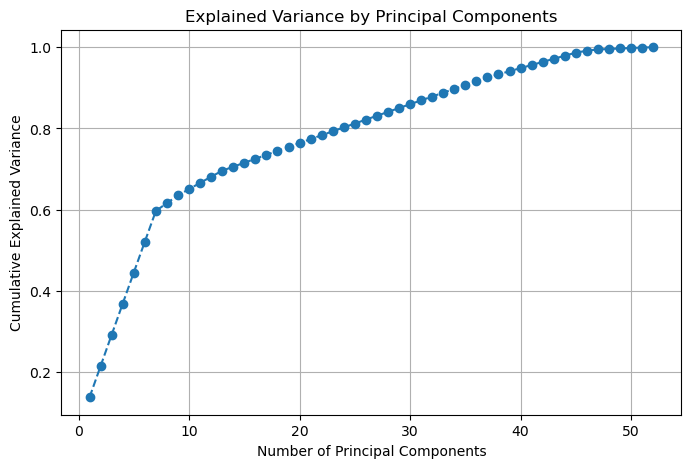

Components to capture 90% variance: 35


In [297]:
# Apply PCA
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Initialize and fit PCA
pca = PCA().fit(X_for_pca)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Determine optimal number of components for desired variance coverage (e.g., 90%)
components_90_variance = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Components to capture 90% variance: {components_90_variance}")

<br>

In [299]:
# Step 4: Transform Data with Optimal PCA Components
pca_optimal = PCA(n_components=components_90_variance)
X_pca_classification = pca_optimal.fit_transform(X_for_pca)

# Proceed with train-test split and classification using X_pca_classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca_classification, y, test_size=0.2, random_state=42)

# Initialize and evaluate classification models
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')


# models with classifiers
models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(),    
    'Decision Tree': DecisionTreeClassifier(),
    'K-Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(),

}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {'Accuracy': accuracy, 'F1 Score': f1}
    print(f"{name}:\nAccuracy: {accuracy:.4f}\nF1 Score: {f1:.4f}")
    print("=" * 40)

Random Forest:
Accuracy: 0.5006
F1 Score: 0.5004
Gradient Boosting:
Accuracy: 0.4978
F1 Score: 0.4973
Logistic Regression:
Accuracy: 0.4964
F1 Score: 0.4963
Decision Tree:
Accuracy: 0.5024
F1 Score: 0.5024
K-Neighbors:
Accuracy: 0.5035
F1 Score: 0.5035
Naive Bayes:
Accuracy: 0.4913
F1 Score: 0.4913
AdaBoost:
Accuracy: 0.4933
F1 Score: 0.4922
XGBoost:
Accuracy: 0.4982
F1 Score: 0.4982


<br>

#### Tuning with some algorithms to enhance performance

In [301]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Downsample for tuning to reduce computation time
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

# Random Forest
param_dist_rf = {
    'n_estimators': [100, 150],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}
random_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist_rf, n_iter=5, scoring='accuracy', n_jobs=-1, cv=3, random_state=42)
random_rf.fit(X_sample, y_sample)
best_rf = random_rf.best_estimator_
print(f"Best Random Forest Parameters: {random_rf.best_params_}")

# Decision Tree
param_dist_dt = {
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5]
}
random_dt = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_dist_dt, n_iter=5, scoring='accuracy', n_jobs=-1, cv=3, random_state=42)
random_dt.fit(X_sample, y_sample)
best_dt = random_dt.best_estimator_
print(f"Best Decision Tree Parameters: {random_dt.best_params_}")

# K-Neighbors
param_dist_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
random_knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist_knn, n_iter=5, scoring='accuracy', n_jobs=-1, cv=3, random_state=42)
random_knn.fit(X_sample, y_sample)
best_knn = random_knn.best_estimator_
print(f"Best K-Neighbors Parameters: {random_knn.best_params_}")


Best Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 10}
Best Decision Tree Parameters: {'min_samples_split': 2, 'max_depth': 15}
Best K-Neighbors Parameters: {'weights': 'distance', 'n_neighbors': 7}


In [303]:
# Evaluating each optimized model individually
models = {
    'Optimized Random Forest': best_rf,
    'Optimized Decision Tree': best_dt,
    'Optimized K-Neighbors': best_knn,
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {'Accuracy': accuracy, 'F1 Score': f1}
    print(f"{name}:\nAccuracy: {accuracy:.4f}\nF1 Score: {f1:.4f}")
    print("=" * 40)


Optimized Random Forest:
Accuracy: 0.4994
F1 Score: 0.4990
Optimized Decision Tree:
Accuracy: 0.5008
F1 Score: 0.4866
Optimized K-Neighbors:
Accuracy: 0.5014
F1 Score: 0.5014


#### Optimized Decision Tree is the best-performing model with the highest accuracy and F1 score
#### But the value is still very low. So we need other mechanism to enhance the performance

<br>

### Feature importance

Best Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 10}
Random Forest Performance:
Accuracy: 0.5000
F1 Score: 0.5000


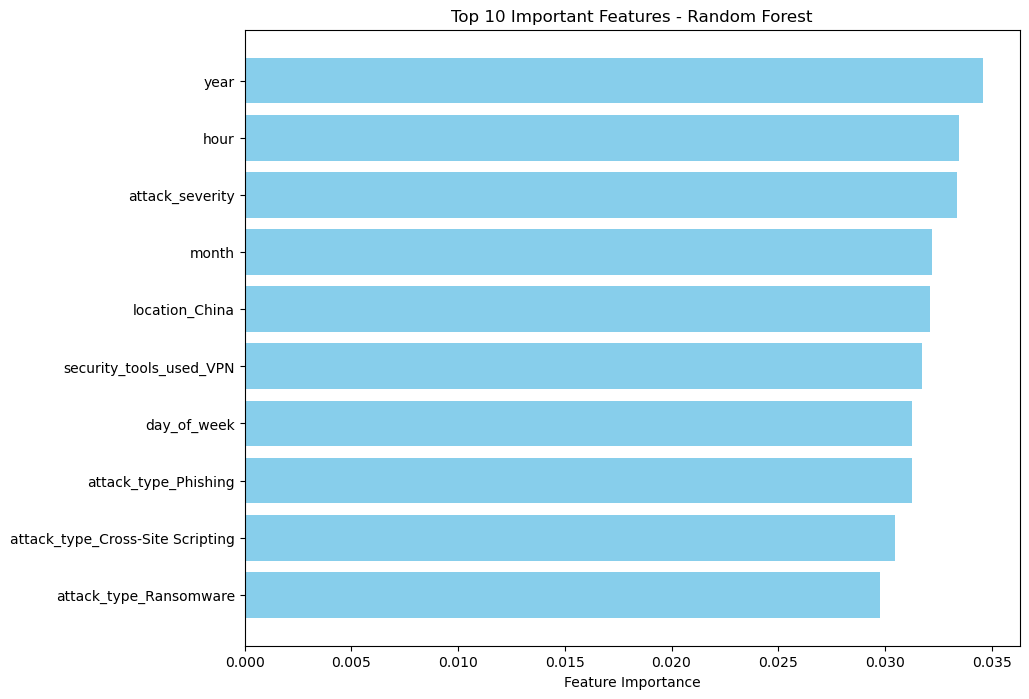

In [237]:
# Store the original feature names from the dataset before preprocessing
original_feature_names = selected_numerical_features + categorical_features

# Random Forest
param_dist_rf = {
    'n_estimators': [100, 150],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}
random_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist_rf, n_iter=5, scoring='accuracy', n_jobs=-1, cv=3, random_state=42)
random_rf.fit(X_sample, y_sample)
best_rf = random_rf.best_estimator_
print(f"Best Random Forest Parameters: {random_rf.best_params_}")

# Train the best Random Forest model on the full training data
best_rf.fit(X_train, y_train)

# Evaluate performance
y_pred_rf = best_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print(f"Random Forest Performance:\nAccuracy: {accuracy_rf:.4f}\nF1 Score: {f1_rf:.4f}")

# Calculate feature importance
feature_importances = best_rf.feature_importances_

# Create a sorted list of features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = [original_feature_names[i] for i in sorted_indices]  # Use stored feature names
sorted_importances = feature_importances[sorted_indices]

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_features[:10][::-1], sorted_importances[:10][::-1], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features - Random Forest")
plt.show()

<br>

<br>

## Since PCA performing poorly, We Droped PCA and Focus on Manual Feature Selection

<br>

#### Import libraries and Load the dataset

In [31]:
# Import necessary libraries
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Load the dataset
data = pd.read_csv('cybersecurity_large_synthesized_data.csv')

#### Feature engeenering timestamp

In [34]:
# Feature Extraction from 'timestamp'
if 'timestamp' in data.columns:
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['year'] = data['timestamp'].dt.year
    data['month'] = data['timestamp'].dt.month
    data['day'] = data['timestamp'].dt.day
    data['hour'] = data['timestamp'].dt.hour
    data = data.drop(columns=['timestamp'], errors='ignore')

#### List of droped irrelevant columns

In [37]:
# Drop irrelevant columns
irrelevant_columns = [
    'attacker_ip', 'target_ip', 'user_role', 
    'location', 'mitigation_method'
]
data = data.drop(columns=irrelevant_columns, errors='ignore')

#### Encoding using label encoder

In [40]:
# Encode categorical variables
categorical_columns = data.select_dtypes(include='object').columns.drop('outcome')
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    data[col] = label_encoders[col].fit_transform(data[col])

# Encode the target variable ('outcome')
target_encoder = LabelEncoder()
data['outcome'] = target_encoder.fit_transform(data['outcome'])

#### Imbalance handling

In [43]:
# Handle class imbalance
X = data.drop(columns=['outcome'])
y = data['outcome']

X_y_balanced = pd.concat([X, y], axis=1)
majority_samples = X_y_balanced[X_y_balanced['outcome'] == 0]
minority_samples = X_y_balanced[X_y_balanced['outcome'] == 1]

minority_upsampled = resample(minority_samples, 
                               replace=True, 
                               n_samples=len(majority_samples), 
                               random_state=42)

balanced_data = pd.concat([majority_samples, minority_upsampled])
X_balanced = balanced_data.drop(columns=['outcome'])
y_balanced = balanced_data['outcome']

# To check class distribution
print("Class distribution in y_balanced:")
print(y_balanced.value_counts())

Class distribution in y_balanced:
outcome
0    49970
1    49970
Name: count, dtype: int64


#### Scalling numeric features

In [46]:
# Scale numeric features
numeric_columns = X_balanced.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_balanced[numeric_columns] = scaler.fit_transform(X_balanced[numeric_columns])

#### data duration interaction feature created/feature engeenered

In [49]:
# Create Interaction Features
X_balanced['data_duration_interaction'] = X_balanced['data_compromised_GB'] * X_balanced['attack_duration_min']

#### Split the data to training and test sets

In [52]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

#### Train and evaluate the modls

In [67]:
# Train and Evaluate Models
models = {
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300, learning_rate=0.02, max_depth=10, subsample=0.85, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators= 300, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.02, max_depth=10, subsample=0.85, colsample_bytree=0.8, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "Decision Tree": DecisionTreeClassifier(max_depth=15, random_state=42)
}

best_model = None
best_accuracy = 0
best_model_name = ""

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy * 100:.2f}%, F1-Score: {f1:.2f}")
    if accuracy > best_accuracy:
        best_model = model
        best_accuracy = accuracy
        best_model_name = model_name

print(f"\nBest model selected: {best_model_name} with accuracy {best_accuracy * 100:.2f}%")

Gradient Boosting Accuracy: 64.98%, F1-Score: 0.65
Random Forest Accuracy: 58.70%, F1-Score: 0.59


C:\Users\sowow\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 63.78%, F1-Score: 0.64
Decision Tree Accuracy: 51.30%, F1-Score: 0.48

Best model selected: Gradient Boosting with accuracy 64.98%


#### Save the Best Model and Feature List for web integration

In [69]:
# Save the Best Model and Feature List
model_path = "../web_integration/backend/model/model.pkl"
compressed_model_path = "../web_integration/backend/model/compressed_model.pkl"
features_list_path = "../web_integration/backend/model/features_list.pkl"

# Save the uncompressed model first (if needed later)
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)

# Compress the model
import joblib
joblib.dump(best_model, compressed_model_path, compress=3)

# Save the features list
with open(features_list_path, "wb") as f:
    pickle.dump(X_balanced.columns.tolist(), f)

print(f"Compressed model and features saved for web integration.")

# Check compressed model size
import os
file_size = os.path.getsize(compressed_model_path) / (1024 * 1024)  # Convert to MB
print(f"Compressed model file size: {file_size:.2f} MB")


Compressed model and features saved for web integration.
Compressed model file size: 9.06 MB


#### Plot Feature Importance for the Best Model

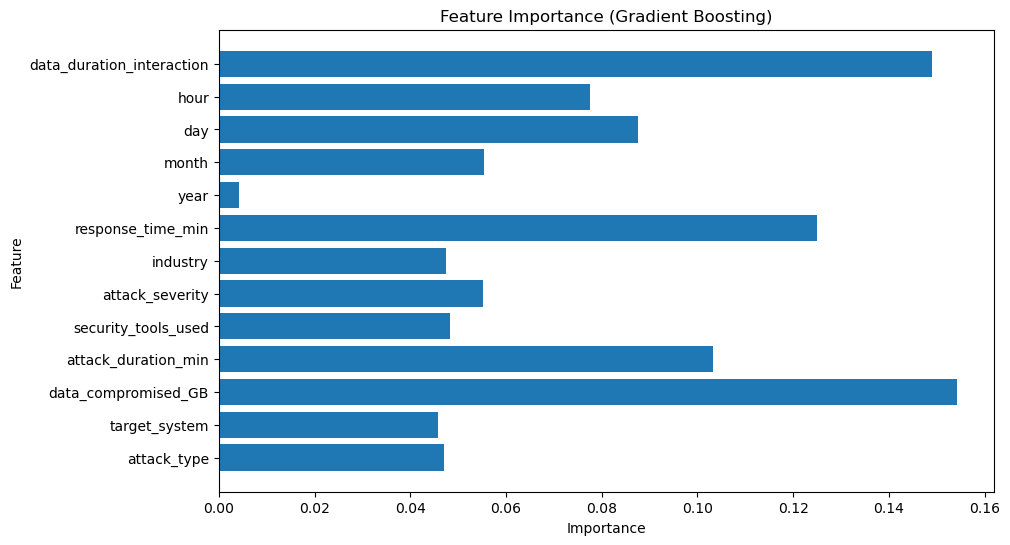

In [71]:
# Plot Feature Importance for the Best Model
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.barh(X_balanced.columns, feature_importances)
    plt.title(f"Feature Importance ({best_model_name})")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print(f"The best model ({best_model_name}) does not support feature importance.")